## Determining Argument Convincingness with Limited and Generic Features
#### Jason Sanchez
#### jason.sanchez@berkeley.edu

### Abstract

Determining which of two arguments is more convincing is a challenging task. Following previous research by Habernal and Gurevych (2016) and Chalaguine and Schulz (2017), this paper demonstrates how to classify which of two arguments is more convincing. 

Habernal and Gurevych trained a 64,000 feature SVC model and a bidirectional LSTM and achieved an accuracy of .78 and .76 respectively. Chalaguine and Schulz trained a model with only 35 features with a .77 accuracy. Their model relied on knowing the debate topics ahead of time and having a sizable example of arguments from each topic. 

This paper demonstrates how we can train a multilayer ensemble model to achieve a .803 accuracy. Furthermore, only 35 features are used and prior knowledge of the debate topics is not required.


### Introduction and background

The dataset consists of argument pairs. For example:

|  |  |
| --- | --- |
| Argument 1 | Bottled water consumption has grown exponentially over the past ten to fifteen years. This growth has taken place globally, but particularly in Europe and North America. The bottled water industry has literally created its own water culture which is good for american industries. |
| Argument 2 | If bottled water did not exist, more people would be drinking sweetened liquids becasue it would be the only portable drinks! People would become fat! |

Groups of five human reviewers selected the argument they found most convincing among 11,650 such argument pairs among 32 different debate topics. See Habernal (2016) for full details of how the dataset was created.

The established evaluation metric on this dataset is group cross-validation accuracy, where each group is one of the 32 debate topics. "Accuracy" in this paper refers to this metric.

Habernal and Gurevych trained a 64,000 feature SVC model and a bidirectional LSTM and achieved an accuracy of .78 and .76 respectively. The LSTM was offered as a simpler alternative compared to the SVC with only a minor reduction in accuracy.

Chalaguine and Schulz trained a model with only 35 features with a .77 accuracy. Their model relied on knowing the debate topics ahead of time and having a sizable example of arguments from each topic. For example, they compared the length of each argument to the average length of an argument in the same debate topic. These groups of features were the most performant features in their model. Without using these features, their model had a .6734 accuracy.

This paper demonstrates how to achieve strong performance with thirty five debate agnostic features using ensemble techniques.

We will investigate which features were important and final model architecture.


### Methods

#### Feature engineering
Thirty five features were created. Every feature is generic which means none depend on prior knowledge of the debate topic. 

Here are the names of which features were used, the variable used to reference the feature in the included code, the type of feature, and each feature's approximate relative importance. 

There are three types of features:
1. Size-based features: Compares arguments based on the lengths of the argument text/tokens.
2. Content-based features: Compares arguments based on words used in the arguments.
3. Structure-based features: Compares arguments based on part-of-speech structure differences.

Importance was estimated using the mean decrease impurity from a Random Forest model trained on the entire dataset. Note, this was the only occurrence where a model was trained on the entire dataset at the same time; all other models were trained on cross-validation training folds. 

<table></table>

Notice that several features had very small importances. These features could be excluded with little impact on final accuracy; however, they were included so future studies could get a baseline expectation of which features are useful.



#### Model architecture
Several model architectures were tested. Ultimately a simple model performed best of all model architectures tested. The chart below shows a high level picture of the model components and the accuracy of each component of the best model.

<chart></chart>

Each individual model's out of fold predictions were used as features in the final ensemble model. By removing one model at a time, we can measure the marginal relative importance of each model in the final ensemble.

<liftchart></liftchart>

Most of the lift from the model comes from the features. We see that several base models have strong performance and the ensemble technique adds ""% lift above the single best model.



### Results and discussion
* Current benchmarks
 * .504 accuracy = baseline score of always predicting the majority class
 * .76 = Habernal and Gurevych Bidirectional LSTM
 * .77 = Chalaguine and Schulz Feedforward Neural Network
 * .7725 = Sanchez Single Feature Model
 * .78 = Habernal and Gurevych 64k feature SVC
 * .805 = Sanchez Ensemble
 * .935 accuracy = score of best human reviewer


* Per class performance
* Model results and per class performance
* Examples of incorrect predictions the model was most certain in and analysis


### Next steps
* Much work to do
* Add Turk agreement labels

.504 accuracy = baseline score of always predicting the majority class
.76 = Habernal and Gurevych Bidirectional LSTM
.77 = Chalaguine and Schulz Feedforward Neural Network
.78 = Habernal and Gurevych 64k feature SVC
.805 = Sanchez Ensemble
.935 accuracy = score of best human reviewer

(0.5, 1)

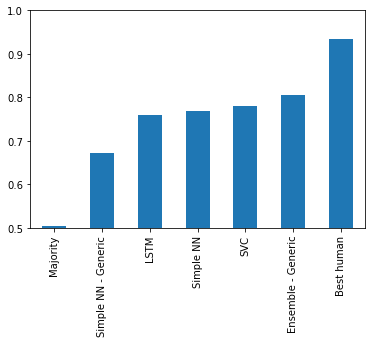

In [100]:
benchmarks = pd.Series([.504, .6734, .76, .77, .78, .805, .935], index=["Majority", "Simple NN - Generic", "LSTM", "Simple NN", "SVC", "Ensemble - Generic", "Best human"])
benchmarks.plot(kind="bar")
plt.ylim(.5, 1)

(0.5, 0.81)

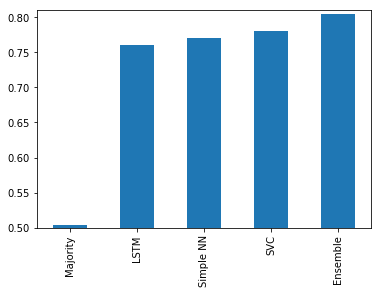

In [97]:
benchmarks = pd.Series([.504, .76, .77, .78, .804], index=["Majority", "LSTM", "Simple NN", "SVC", "Ensemble"])
benchmarks.plot(kind="bar")
plt.ylim(.5, .81)

In [ ]:
X_raw.shape

* Argumentation analysis is important
* Major ideas:
 * Problem is challenging because observations are not independent. Models that presume independence of obs will not generalize as well. Explain independence issue.
 * Generic features are critical to generalizable models
 * Ensembling is feature engineering


### Background
* Dataset description
* Prior approaches
 * Habernal 
 * Chalaguine
 

### Methods
* Features used and importances with RF
* Chart of model architecture


### Results and discussion
* Current benchmarks
* Per class performance
* Model results and per class performance
* Examples of incorrect predictions the model was most certain in and analysis
* 


### Conclusion
* Model is currently the best at this task
* Distinction between knowing why an argument is better and being able to predict better arguments (i.e. longer = better)
* Problem continues to be difficult

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from nltk import word_tokenize, pos_tag, download
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

download('punkt')
download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: HTTP Error 405: Not allowed.
[nltk_data] Error loading averaged_perceptron_tagger: HTTP Error 405:
[nltk_data]     Not allowed.


False

Read in data

In [2]:
path_to_compare_data_1 = "data/UKPConvArg1Strict-CSV/"

files = listdir(path_to_compare_data_1)

all_data = []

for f in files:
    path = path_to_compare_data_1 + f
    one_argument = pd.read_csv(path, sep="\t")
    one_argument["argument_group"] = f
    all_data.append(one_argument)
    
X_raw = pd.concat(all_data).reset_index(drop=True)
X_raw.head()

,#id,label,a1,a2,argument_group
0,arg219237_arg219207,a2,"jesus loves plastic water bottles, and you can...",Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
1,arg219203_arg219206,a2,The American Water companies are Aquafina (Pep...,Americans spend billions on bottled water ever...,ban-plastic-water-bottles_no-bad-for-the-econo...
2,arg219225_arg219284,a1,Banning plastic bottled water would be a huge ...,God created water bottles for a reason. Becaus...,ban-plastic-water-bottles_no-bad-for-the-econo...
3,arg219216_arg219207,a2,The water bottles are a safe source of water a...,Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
4,arg219207_arg219294,a1,Bottled water consumption has grown exponentia...,"If bottled water did not exist, more people wo...",ban-plastic-water-bottles_no-bad-for-the-econo...


In [3]:
y_raw = X_raw.pop("label")
y_raw.head()

0    a2
1    a2
2    a1
3    a2
4    a1
Name: label, dtype: object

Create base dataset. Make y an integer and rename the arguments to use zero-based indexing.

In [4]:
%%time
y = (y_raw == "a2").astype(int)
X = X_raw.drop(["#id"], axis=1)
X.columns = ["a0", "a1", "argument_group"]

def sentence_tags(text):
#     text = text.decode('utf-8')
    tags = pos_tag(word_tokenize(text))
    only_tags = [t[1] for t in tags]
    return " ".join(only_tags)

X["a0_tags"] = X.a0.apply(sentence_tags)
X["a1_tags"] = X.a1.apply(sentence_tags)

X.head()

Wall time: 1min 41s


In [5]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: label, dtype: int32

Build a benchmark model as fast as possible.

In [94]:
transition_words = set(['similarly', 'foremost', 'presumably', 'moreover', 'however', 'reason', 'otherwise', 'second,', 'still', 'first', 'even', 'ultimately', 'finally', 'therefore', 'addition', 'next', 'also', 'furthermore', 'conclusion', 'third', 'hand', 'another'])
misspelled_words = set(['wouldn', 'dont', 'shouldn', 'india', 'firefox', 'didn', 'wouldnt', 'doesnt', 'thier', 'farquhar', 'couldn', 'commited', 'adam', 'theyre', 'sabrejimmy', 'persuit', 'definately', 'shouldnt', 'marrage', 'syona', 'alot', 'beleive', 'donot', 'commen', 'especialy', 'dicipline', 'arguement', 'likley', 'lously', 'havn', 'alcohlic', 'wasnt', 'aint', 'bcoz', 'hace', 'decir', 'planta', 'politian', 'acomplice', 'definetly', 'incestual', 'chasbas', 'soooo', 'coolio', 'hoolio', 'infront', 'creatoinism', 'enviroment', 'hasn', 'becasue', 'farquer', 'xada', 'atrever', 'menos', 'dathu', 'ihfej', 'humano', 'charector', 'blimem', 'shld', 'urself', 'tijkjdrk', 'sholud', 'jarman', 'responsibilily', 'preverted', 'plantas', 'aunque', 'sayin', 'xadgeno', 'imformation', 'xbanico', 'sfjiiytg', 'negleted', 'chupar', 'guil', 'xtklp', 'incharge', 'telvisions', 'telivision', 'igual', 'recursos', 'ushould', 'thik', 'supress', 'querido', 'idioma', 'unforms', 'unatrel', 'cauntious', 'evrybdy', 'bookxx', 'beleifs', 'eles', 'completly', 'isnot', 'beleave', 'beter', 'llaman', 'wdout', 'smoken', 'facr', 'illegaly', 'nowadayz', 'doont', 'somkers', 'somke', 'responsiblity', 'homosapien', 'dissappointed', 'criterium', 'hets', 'doughter', 'posible', 'strategizing', 'succeful', 'probaly', 'atleast', 'beileve', 'vida', 'pero', 'mench', 'playstations', 'niega', 'importhant', 'pensar', 'sentir', 'puede', 'aslong', 'ciggarettes', 'sooooooo', 'ebil', 'sito', 'botherd', 'diegnosedca', 'humanos', 'animales', 'suelen', 'aborto', 'matar', 'bullsh', 'employe', 'evryone', 'benifit', 'enviorment', 'lookin', 'persue', 'diffenrent', 'embroyo', 'undertsand', 'interveiw', 'becouse', 'afterschool', 'diferent', 'highschool', 'alreaddy', 'leagal', 'unpetty', 'themselfs', 'yoursel', 'defenceless', 'absolutley', 'peices', 'advencing', 'isnt', 'inequal', 'instinc', 'succesful', 'insctinc', 'disapointment', 'organisation', 'beemed', 'succeded', 'woulld', 'excuss', 'chil', 'singapura', 'majulah', 'mothernature', 'wannna', 'compulsaryy', 'preggo', 'weren', 'dieases', 'relize', 'coloured', 'actualy', 'expirience', 'itll', 'obecity', 'personhood', 'dosent', 'clases', 'mandortory', 'excersise', 'whloe', 'manditory', 'howzz', 'definatley', 'expirence', 'benifits', 'licence', 'echoworld', 'lieing', 'othr', 'alow', 'overal', 'theri', 'stoping', 'selfes', 'becoz', 'mmorning', 'mustn', 'espeacilly', 'perfomed', 'exersises', 'thankyou', 'dreamt', 'theirself', 'cuhz', 'learnt', 'malay', 'proble', 'wether', 'newscientist', 'evealution', 'makind', 'beleivers', 'argumentum', 'populum', 'extreamly', 'callad', 'beleives', 'scientologists', 'aquire', 'existance', 'addons', 'fanboy', 'realeased', 'wayyyyy', 'pointlessss', 'enititys', 'microsot', 'stylesheets', 'google', 'toolbar', 'phro', 'tohttp', 'evol', 'dinosauria', 'neccisary', 'varifiable', 'usgs', 'envirnment', 'nuff', 'polandspring', 'aspx', 'duboard', 'criters', 'worryz', 'excrament', 'produceing', 'evironment', 'poluted', 'healthywater', 'hypocryte', 'friendsjournal', 'garentee', 'compostable', 'youre', 'serval', 'comfortabley', 'suply', 'nikawater', 'nestlewaterscorporate', 'equis', 'ditrabutions', 'treehugger', 'extremly', 'weve', 'aynrandlexicon', 'flipppin', 'belivers', 'religon', 'biggots', 'athieists', 'besause', 'indepent', 'healp', 'lawl', 'sunday', 'spamming', 'therfore', 'recognise', 'simplier', 'didnt', 'xafsm', 'disputs', 'superbrain', 'politians', 'hitech', 'illitrate', 'literated', 'enought', 'specialy', 'fricken', 'opressed', 'illeteracy', 'toughy', 'somone', 'muder', 'marrie', 'sombody', 'accompalice', 'incase', 'hurst', 'basicly', 'preffer', 'nothong', 'tounges', 'contries', 'forgeting', 'ndians', 'hardwork', 'languags', 'utillised', 'prsns', 'ptential', 'manufactoring', 'dependant', 'alawys', 'violance', 'dissapointed', 'tought', 'figuer', 'msitake', 'arent', 'ooooooooh', 'sush', 'differnce', 'wats', 'aryabhatta', 'chatng', 'debatng', 'partical', 'pottential', 'nuissance', 'nalanda', 'jagah', 'achcha', 'hamara', 'britishers', 'orginal', 'americans', 'rama', 'krishna', 'vishvamitr', 'vishvguru', 'francisco', 'nutjobes', 'certainley', 'needn', 'roomates', 'marraige', 'secuality', 'respecful', 'harrassed', 'veiws', 'centry', 'commiting', 'beacuse', 'adware', 'nobrob', 'enuff', 'preinstall', 'derrrr', 'imho', 'weatherfox', 'apps', 'novanet', 'perfrom', 'popup', 'avaible', 'tooltip', 'spaking', 'saame', 'butthole', 'belifs', 'eachother', 'hackman', 'involed', 'throught', 'defence', 'worng', 'couldnt', 'reponsiblity', 'wong', 'woppen', 'nessasary', 'prenup', 'becuase', 'liklihood', 'couse', 'contriverse', 'accomodate', 'extrem', 'pepole', 'accomodations', 'sucied', 'wakoness', 'absoultly'])
slang_words = set(['creep', 'jerk', 'basic', 'wicked', 'diss', 'props', 'unreal', 'dig', 'ripped', 'swole', 'wrecked', 'wasted', 'busted', 'awesome', 'trip', 'cool', 'chilling', 'chill', 'amped', 'blast', 'crush', 'dump', 'geek', 'sick', 'toasted', 'fail', 'epic', 'dunno', 'loser', 'rip', 'off', 'beat', 'bling', 'break', 'cheesy', 'cop', 'out', 'da', 'bomb', 'dope', 'downer', 'fab', 'flake', 'freak', 'disgusting', 'hooked', 'fleet', 'flawless', 'snatched', 'shorty', 'grill', 'hustle', 'grind', 'beef', 'fresh', 'word', 'wack', 'def', 'skeeze', 'ill', 'dough', 'mooch', 'boo', 'baller', 'bromance', 'dawg', 'dude', 'lol', 'ratchet', 'selfie', 'sweet', 'woke', 'neat', 'kidding', 'agame', 'bro', 'cash', 'cop', 'hip', 'jacked', 'hype', 'score', 'trash', 'riled', 'pissed', 'bummer', 'check', 'dead', 'totes'])
important_parts_of_speech = ["vbp", "vbp prp", "nn nn", "to", "dt", "dt nn", "cc"]


def n_general_transitions(x):
    words = x.split()
    total = 0
    for w in words:
        if w in transition_words:
            total += 1
    return total


def n_misspelled_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in misspelled_words:
            total += 1
    return total


def n_slang_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in slang_words:
            total += 1
    return total


def percent_unique(x):
    words = x.split()
    unique = set(words)
    percent_unique = len(unique)/len(words)
    return percent_unique


def word_length_variability(x):
    words = x.split()
    lengths = []
    for word in words:
        lengths.append(len(word))
    return np.array(lengths).std()


def percent_one_letter_words(x):
    words = x.split()
    counts = 0
    for word in words:
        if len(word) == 1: counts += 1
    return counts/len(words)


class TextBasedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        a0_raw = X.a0
        a1_raw = X.a1
        a0_simple = a0_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a1_simple = a1_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a0 = a0_simple.str
        a1 = a1_simple.str
        
        # a0 features
        X["characters_a0"] = a0.len()
        X["pronoun_counts_a0"] = a0.count(" you ") + a0.count(" i ") + a0.count(" me ") + a0.count(" my ")
        X["certain_lang_counts_a0"] = a0.count(" always ") + a0.count(" never ") + a0.count(" impossible ")
        X["uncertain_lang_counts_a0"] = a0.count(" believe ") + a0.count(" think ") + a0.count(" feel ")
        X["bold_counts_a0"] = a0_raw.str.count("<br/>")
        X["because_counts_a0"] = a0_raw.str.count("because")
        X["quote_counts_a0"] = a0_raw.str.count("[\"']")
        X["comma_counts_a0"] = a0_raw.str.count(",")
        X["words_a0"] = a0.count(" ") + 1
        X["total_punctuation_a0"] = a0_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a0"] = X["total_punctuation_a0"]/X["characters_a0"]
        X["end_of_sentence_punct_counts_a0"] = a0_raw.str.count("[!?.][ \n]")
        X["sentence_counts_a0"] = X["end_of_sentence_punct_counts_a0"] + X["no_sentence_punctuation_a0"]
        X["average_sentence_word_len_a0"] = X["words_a0"]/X["sentence_counts_a0"]
        X["average_sentence_char_len_a0"] = X["characters_a0"]/X["sentence_counts_a0"]
        X["average_word_length_a0"] = X["characters_a0"]/X["words_a0"]
        X["n_transitions_a0"] = a0_simple.apply(n_general_transitions)
        X["n_misspelled_a0"] = a0_simple.apply(n_misspelled_words)
        X["n_slang_words_a0"] = a0_simple.apply(n_slang_words)
        X["percent_words_unique_a0"] = a0_simple.apply(percent_unique)
        X["first_word_capitalized_a0"] = a0_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a0"] = a0_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a0"] = a0_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a0"] = a0_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["vbp_a0"] = X.a0_tags.str.count("VBP")
        X["vbp_prp_a0"] = X.a0_tags.str.count("VBP PRP")
        X["nn_nn_a0"] = X.a0_tags.str.count("NN NN")
        X["to_a0"] = X.a0_tags.str.count("TO")
        X["dt_a0"] = X.a0_tags.str.count("DT")
        X["dt_nn_a0"] = X.a0_tags.str.count("DT NN")
        X["cc_a0"] = X.a0_tags.str.count("CC")
        X["word_len_var_a0"] = a0_simple.apply(word_length_variability)
        X["perc_one_letter_a0"] = a0_simple.apply(percent_one_letter_words)

        # a1 features
        X["characters_a1"] = a1.len()
        X["pronoun_counts_a1"] = a1.count(" you ") + a1.count(" i ") + a1.count(" me ") + a1.count(" my ")
        X["certain_lang_counts_a1"] = a1.count(" always ") + a1.count(" never ") + a1.count(" impossible ")
        X["uncertain_lang_counts_a1"] = a1.count(" believe ") + a1.count(" think ") + a1.count(" feel ")
        X["bold_counts_a1"] = a1_raw.str.count("<br/>")
        X["because_counts_a1"] = a1_raw.str.count("because")
        X["quote_counts_a1"] = a1_raw.str.count("[\"']")
        X["comma_counts_a1"] = a1_raw.str.count(",")
        X["words_a1"] = a1.count(" ") + 1
        X["total_punctuation_a1"] = a1_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a1"] = X["total_punctuation_a1"]/X["characters_a1"]
        X["end_of_sentence_punct_counts_a1"] = a1_raw.str.count("[!?.][ \n]")
        X["sentence_counts_a1"] = X["end_of_sentence_punct_counts_a1"] + X["no_sentence_punctuation_a1"]
        X["average_sentence_word_len_a1"] = X["words_a1"]/X["sentence_counts_a1"]
        X["average_sentence_char_len_a1"] = X["characters_a1"]/X["sentence_counts_a1"]
        X["average_word_length_a1"] = X["characters_a1"]/X["words_a1"]
        X["n_transitions_a1"] = a1_simple.apply(n_general_transitions)
        X["n_misspelled_a1"] = a1_simple.apply(n_misspelled_words)
        X["n_slang_words_a1"] = a1_simple.apply(n_slang_words)
        X["percent_words_unique_a1"] = a1_simple.apply(percent_unique)
        X["first_word_capitalized_a1"] = a1_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a1"] = a1_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a1"] = a1_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a1"] = a1_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["vbp_a1"] = X.a1_tags.str.count("VBP")
        X["vbp_prp_a1"] = X.a1_tags.str.count("VBP PRP")
        X["nn_nn_a1"] = X.a1_tags.str.count("NN NN")
        X["to_a1"] = X.a1_tags.str.count("TO")
        X["dt_a1"] = X.a1_tags.str.count("DT")
        X["dt_nn_a1"] = X.a1_tags.str.count("DT NN")
        X["cc_a1"] = X.a1_tags.str.count("CC")
        X["word_len_var_a1"] = a1_simple.apply(word_length_variability)
        X["perc_one_letter_a1"] = a1_simple.apply(percent_one_letter_words)
        
        # diff features
        X["character_diff"] = X["characters_a0"] - X["characters_a1"]
        X["character_diff_percent"] = X["character_diff"]/X["characters_a1"]
        X["pronoun_count_diff"] = X["pronoun_counts_a0"] - X["pronoun_counts_a1"]
        X["certain_language_diff"] = X["certain_lang_counts_a0"] - X["certain_lang_counts_a1"]
        X["uncertain_language_diff"] = X["uncertain_lang_counts_a0"] - X["uncertain_lang_counts_a1"]
        X["bold_counts_diff"] = X["bold_counts_a0"] - X["bold_counts_a1"]
        X["because_counts_diff"] = X["because_counts_a0"] - X["because_counts_a1"]
        X["quote_counts_diff"] = X["quote_counts_a0"] - X["quote_counts_a1"]
        X["comma_counts_diff"] = X["comma_counts_a0"] - X["comma_counts_a1"]
        X["words_diff"] = X["words_a0"] - X["words_a1"]
        X["words_diff_percent"] = X["words_diff"]/X["words_a1"]
        X["punctuation_percent_diff"] = X["punctuation_percent_a0"] - X["punctuation_percent_a1"]
        X["punctuation_percent_diff_percent"] = X["punctuation_percent_diff"]/(X["punctuation_percent_a1"] + 1)
        X["sentence_diff"] = X["sentence_counts_a0"] - X["sentence_counts_a1"]
        X["average_sentence_word_len_diff"] = X["average_sentence_word_len_a0"] - X["average_sentence_word_len_a1"]
        X["average_sentence_char_len_diff"] = X["average_sentence_char_len_a0"] - X["average_sentence_char_len_a1"]
        X["average_word_length_diff"] = X["average_word_length_a0"] - X["average_word_length_a1"]
        X["average_word_length_diff_percent"] = X["average_word_length_diff"]/X["average_word_length_a1"]
        X["n_transitions_diff"] = X["n_transitions_a0"] - X["n_transitions_a1"]
        X["n_misspelled_diff"] = X["n_misspelled_a0"] - X["n_misspelled_a1"]
        X["n_slang_diff"] = X["n_slang_words_a0"] - X["n_slang_words_a1"]
        X["percent_words_unique_diff"] = X["percent_words_unique_a0"] - X["percent_words_unique_a1"]
        X["first_word_cap_diff"] = X["first_word_capitalized_a0"] - X["first_word_capitalized_a1"]
        X["n_proper_nouns_diff"] = X["n_proper_nouns_a0"] - X["n_proper_nouns_a1"]
        X["all_caps_words_diff"] = X["all_caps_words_a0"] - X["all_caps_words_a1"]
        X["n_digits_diff"] = X["n_digits_a0"] - X["n_digits_a1"]
        X["vbp_diff"] = X["vbp_a0"] - X["vbp_a1"]
        X["vbp_prp_diff"] = X["vbp_prp_a0"] - X["vbp_prp_a1"]
        X["nn_nn_diff"] = X["nn_nn_a0"] - X["nn_nn_a1"]
        X["to_diff"] = X["to_a0"] - X["to_a1"]
        X["dt_diff"] = X["dt_a0"] - X["dt_a1"]
        X["dt_nn_diff"] = X["dt_nn_a0"] - X["dt_nn_a1"]
        X["cc_diff"] = X["cc_a0"] - X["cc_a1"]  
        X["word_len_var_diff"] = X["word_len_var_a0"] - X["word_len_var_a1"]
        X["perc_one_letter_diff"] = X["perc_one_letter_a0"] - X["perc_one_letter_a1"]
        return X

    
class KeepNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.numeric_columns = X.dtypes[X.dtypes != "object"].index.tolist()
        return self
        
    def transform(self, X, y=None):
        return X[self.numeric_columns]

    
class OnlyDiffs(BaseEstimator, TransformerMixin):
    def __init__(self, on=True):
        self.on = on
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.on:
            diff_cols = [c for c in X.columns if "diff" in c]
            other_cols = ["a0_tags", "a1_tags"]
            return X[diff_cols+other_cols]
        else:
            return X
    

class ColNames(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        return X
    
    
def accuracy(y, y_hat, threshold=.5):
    if (len(y_hat.shape) == 2) and (y_hat.shape[1] == 2):
        y_hat = y_hat[:,1]
    return accuracy_score(y, y_hat>threshold)

In [65]:
group_cv = LeaveOneGroupOut()
group_cv.get_n_splits(X, y, X.argument_group)

32

In [66]:
%%time

steps = [("simple_features", TextBasedFeatures()),
         ("only_diff_columns", OnlyDiffs(on=True)),
         ("keep_numeric_only", KeepNumeric()),
         ("col_names", ColNames())]

pipe = Pipeline(steps)

X_clean = pipe.fit_transform(X, y)

Wall time: 2.49 s


Feature importances

In [78]:
rf_imp = RandomForestClassifier(n_estimators=1000, max_features=None,
                                n_jobs=-1,
                                random_state=42)
rf_imp.fit(X_clean, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

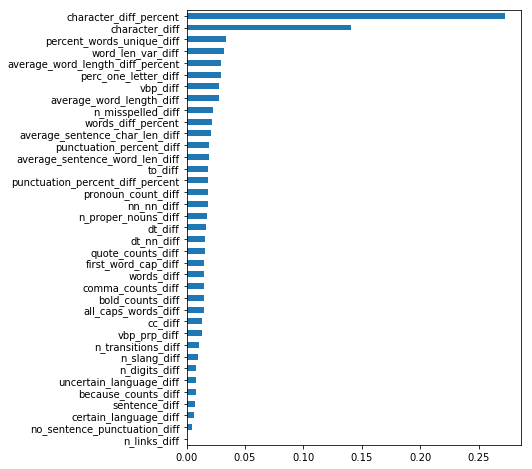

In [79]:
feature_importances = pd.Series(rf_imp.feature_importances_, index=X_clean.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(6,8))

In [69]:
feature_importances.sort_values(ascending=False)

character_diff_percent              0.113098
character_diff                      0.105446
words_diff_percent                  0.082804
words_diff                          0.064360
percent_words_unique_diff           0.047710
average_word_length_diff            0.038014
average_word_length_diff_percent    0.037447
dt_diff                             0.033463
word_len_var_diff                   0.030177
perc_one_letter_diff                0.025331
dt_nn_diff                          0.025085
punctuation_percent_diff_percent    0.024454
punctuation_percent_diff            0.024302
average_sentence_char_len_diff      0.023856
cc_diff                             0.023595
to_diff                             0.022957
vbp_diff                            0.022177
average_sentence_word_len_diff      0.022107
n_misspelled_diff                   0.020370
comma_counts_diff                   0.018925
n_proper_nouns_diff                 0.018145
pronoun_count_diff                  0.017942
quote_coun

In [43]:
feature_importances.index[:5]

Index(['n_links_diff', 'certain_language_diff', 'no_sentence_punctuation_diff',
       'n_digits_diff', 'because_counts_diff'],
      dtype='object')

In [89]:
X_clean = X_clean[["character_diff_percent"]]

In [81]:
%%time

rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            random_state=42)

rf_predictions = cross_val_predict(rf, 
                                   X_clean, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]

print(accuracy(y, rf_predictions))

0.730386266094
Wall time: 59.9 s


In [90]:
%%time

scale = StandardScaler()
lr = LogisticRegression(C=0.00125, random_state=42)
lr_pipe = Pipeline([("scale", scale), 
                    ("model", lr)])

lr_predictions = cross_val_predict(lr_pipe, 
                                   X_clean, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_predictions))

0.747210300429
Wall time: 4.82 s


In [91]:
%%time

best_params_from_gridsearch = {
    'learning_rate': 0.05,
    'loss': 'deviance',
    'max_depth': 3,
    'max_features': 1.0,
    'subsample': 0.3}

gb = GradientBoostingClassifier(random_state=42, 
                                **best_params_from_gridsearch)

gb_predictions = cross_val_predict(gb, 
                                   X_clean, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]

print(accuracy(y, gb_predictions))

0.772532188841
Wall time: 6.12 s


In [92]:
%%time

knn = KNeighborsClassifier(n_neighbors=35, n_jobs=-1)
scale_knn = StandardScaler()

knn_pipe = Pipeline([("scale", scale_knn), 
                     ("model", knn)])

knn_predictions = cross_val_predict(knn_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, knn_predictions))

0.767982832618
Wall time: 5.1 s


In [85]:
%%time

pt = Perceptron(random_state=42, n_jobs=-1)
scale_pt = StandardScaler()

pt_pipe = Pipeline([("scale", scale_pt), 
                     ("model", pt)])

pt_predictions = cross_val_predict(pt_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict')
print(accuracy(y, pt_predictions))

0.709527896996
Wall time: 5.04 s


In [93]:
%%time

best_params = {
    'alpha': 0.0001,
    'beta_1': 0.94,
    'hidden_layer_sizes': (10, 6),
    'learning_rate_init': 0.002}

mlp = MLPClassifier(random_state=42, **best_params)

scale_mlp = StandardScaler()

mlp_pipe = Pipeline([("scale", scale_mlp), 
                     ("model", mlp)])

mlp_predictions = cross_val_predict(mlp_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, mlp_predictions))

0.77313304721
Wall time: 14.2 s


Layer one ensemble

In [87]:
X_ens_1 = pd.DataFrame()
X_ens_1["rf"] = rf_predictions
X_ens_1["lr"] = lr_predictions
X_ens_1["gb"] = gb_predictions
X_ens_1["knn"] = knn_predictions
X_ens_1["pt"] = pt_predictions
X_ens_1["mlp"] = mlp_predictions

In [88]:
%%time

lr = LogisticRegression(C=0.5, random_state=42)

lr_ens_1_predictions = cross_val_predict(lr, 
                                   X_ens_1, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_ens_1_predictions))

0.77330472103
Wall time: 5.21 s


In [63]:
%%time

lr = LogisticRegression(C=0.5, random_state=42)

lr_ens_1_predictions = cross_val_predict(lr, 
                                   X_ens_1, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_ens_1_predictions))

0.805321888412
Wall time: 4.93 s


In [52]:
%%time

lr = LogisticRegression(C=0.5, random_state=42)

lr_ens_1_predictions = cross_val_predict(lr, 
                                   X_ens_1, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_ens_1_predictions))

0.803862660944
Wall time: 4.85 s


In [27]:
%%time

for model_to_drop in X_ens_1.columns:
    print(model_to_drop)
    X_ens_1_temp = X_ens_1.copy()
    X_ens_1_temp = X_ens_1_temp.drop([model_to_drop], axis=1)

    lr = LogisticRegression(C=0.5, random_state=42)

    lr_ens_1_predictions = cross_val_predict(lr, 
                                       X_ens_1_temp, 
                                       y, 
                                       cv=group_cv, 
                                       groups=X.argument_group, 
                                       n_jobs=-1, 
                                       method='predict_proba')[:,1]
    print(accuracy(y, lr_ens_1_predictions))
    lr.fit(X_ens_1_temp, y)
    print(pd.Series(lr.coef_[0], index=list(X_ens_1_temp.columns)))
    print()

rf
0.802660944206
lr     2.283983
gb     2.685078
knn   -0.392785
pt     0.122376
mlp    1.145022
dtype: float64

lr
0.802145922747
rf     2.712612
gb     1.151931
knn    0.176760
pt     0.133442
mlp    1.469625
dtype: float64

gb
0.804978540773
rf     3.225946
lr     2.487987
knn   -0.710722
pt     0.092963
mlp    0.939386
dtype: float64

knn
0.803862660944
rf     2.657464
lr     1.952294
gb     0.395590
pt     0.084557
mlp    0.920477
dtype: float64

pt
0.805236051502
rf     2.879334
lr     2.430326
gb     0.548063
knn   -0.747601
mlp    0.923338
dtype: float64

mlp
0.803605150215
rf     3.102164
lr     2.951968
gb     0.779749
knn   -0.794920
pt     0.118503
dtype: float64

Wall time: 29.4 s
